In [1]:
!pip install yfinance statsmodels pmdarima matplotlib
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
import itertools
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.0 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


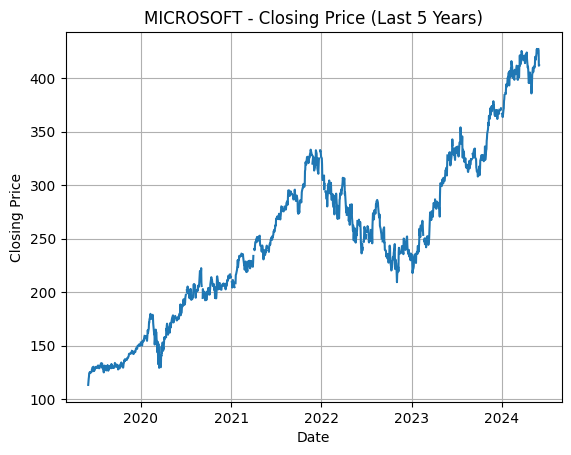

In [13]:
data = yf.download("MSFT", start="2019-06-01", end="2024-06-01")['Close']
data.dropna(inplace=True)
data = data.asfreq('B')  # Setting business day frequency
plt.plot(data)
plt.title("MICROSOFT - Closing Price (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid()
plt.show()

In [14]:
result = adfuller(data.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])
if result[1] < 0.05:
    print("=> Data is stationary.")
else:
    print("=> Data is non-stationary.")


ADF Statistic: -0.5052019224208469
p-value: 0.8909973723898741
Critical Values: {'1%': np.float64(-3.4355964295197743), '5%': np.float64(-2.863856825923603), '10%': np.float64(-2.5680035060041626)}
=> Data is non-stationary.


In [15]:
d = 0
diff_data = data.copy()
while True:
    result = adfuller(diff_data.dropna())
    if result[1] < 0.05:
        break
    diff_data = diff_data.diff().dropna()
    d += 1

print(f"\nMade data stationary by differencing {d} time(s)")


Made data stationary by differencing 1 time(s)


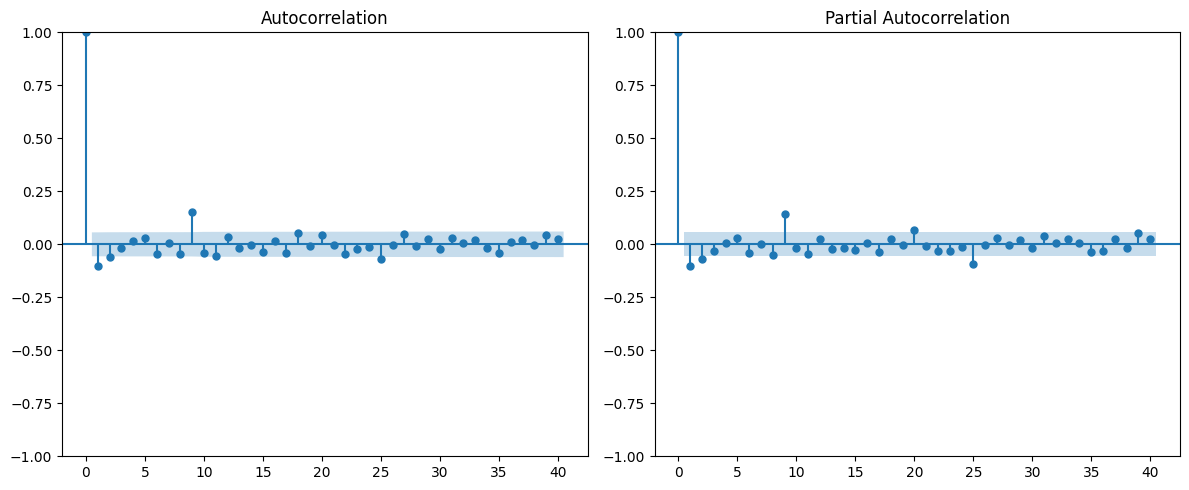

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(diff_data, ax=plt.gca(), lags=40)
plt.subplot(1, 2, 2)
plot_pacf(diff_data, ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Defining p, d, q range
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
split = int(len(data) * 0.95) #testing on data of roughly 3 months
train, test = data[:split], data[split:]
print("Trying combinations:")
for order in pdq:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        print(f"ARIMA{order} AIC: {model_fit.aic}")
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
    except:
        continue

print("\nBest ARIMA order:", best_order)


Trying combinations:
ARIMA(0, 0, 0) AIC: 13565.840868551573
ARIMA(0, 0, 1) AIC: 12128.679627407993
ARIMA(0, 0, 2) AIC: 10968.297064451477
ARIMA(0, 0, 3) AIC: 10099.35514057419
ARIMA(0, 1, 0) AIC: 6964.011796860585
ARIMA(0, 1, 1) AIC: 6949.878217937092
ARIMA(0, 1, 2) AIC: 6950.957360754497
ARIMA(0, 1, 3) AIC: 6952.899495680056
ARIMA(0, 2, 0) AIC: 7934.566263895389
ARIMA(0, 2, 1) AIC: 6964.677899753816
ARIMA(0, 2, 2) AIC: 6949.714969436115
ARIMA(0, 2, 3) AIC: 6950.580728479947
ARIMA(0, 3, 0) AIC: 9306.472960514391
ARIMA(0, 3, 1) AIC: 7938.11104824539
ARIMA(0, 3, 2) AIC: 6980.765881873518
ARIMA(0, 3, 3) AIC: 6968.854098364769
ARIMA(1, 0, 0) AIC: 6980.275173147474
ARIMA(1, 0, 1) AIC: 6966.3675691276585
ARIMA(1, 0, 2) AIC: 6967.3896214684555
ARIMA(1, 0, 3) AIC: 6969.339171375732
ARIMA(1, 1, 0) AIC: 6950.9672269928005
ARIMA(1, 1, 1) AIC: 6950.959824552516
ARIMA(1, 1, 2) AIC: 6952.933701062981
ARIMA(1, 1, 3) AIC: 6954.879395421549
ARIMA(1, 2, 0) AIC: 7517.900971554864
ARIMA(1, 2, 1) AIC: 6950

In [18]:
model = ARIMA(train, order = best_order)
model_fit = model.fit()
print(model_fit.summary())

arima_forecast = model_fit.forecast(steps=len(test))
arima_fitted_values = model_fit.fittedvalues
arima_forecast.index = test.index


                               SARIMAX Results                                
Dep. Variable:                   MSFT   No. Observations:                 1239
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -3467.620
Date:                Sat, 28 Jun 2025   AIC                           6945.240
Time:                        21:58:58   BIC                           6970.842
Sample:                    06-03-2019   HQIC                          6954.870
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9768      0.010    -95.525      0.000      -0.997      -0.957
ma.L1         -0.1333   2023.703  -6.58e-05      1.000   -3966.518    3966.251
ma.L2         -0.9999   1754.066     -0.001      1.0

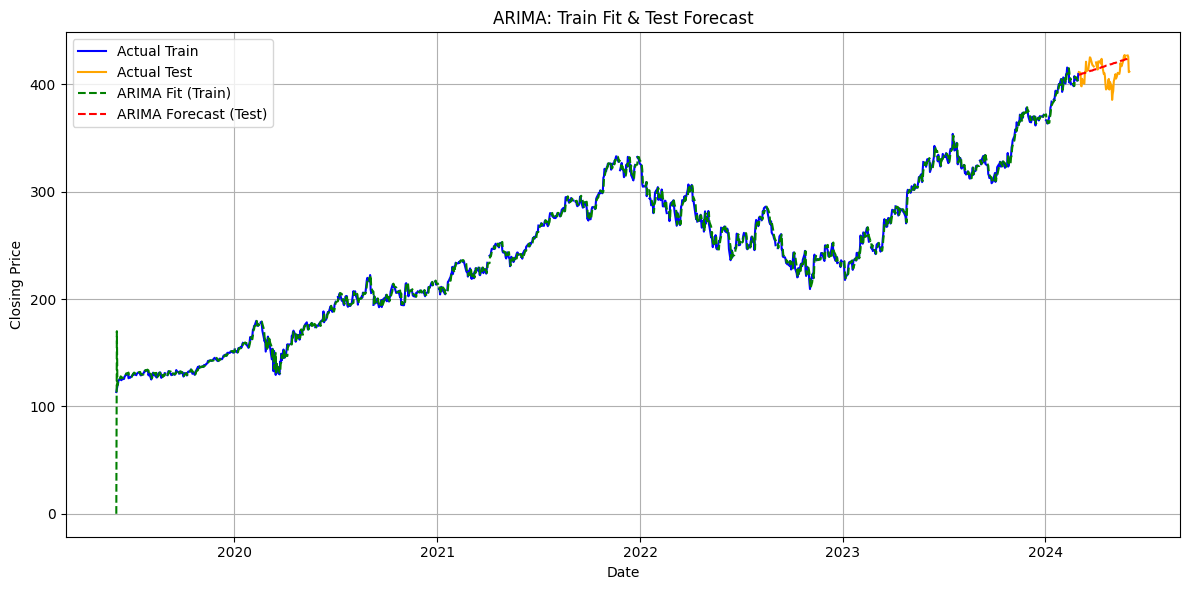

In [19]:
plt.figure(figsize=(12, 6))

# Plot actual train and test
plt.plot(train, label="Actual Train", color='blue')
plt.plot(test, label="Actual Test", color='orange')

# Plot fitted values on train
plt.plot(arima_fitted_values, label="ARIMA Fit (Train)", color='green', linestyle='--')

# Plot forecast on test
plt.plot(arima_forecast, label="ARIMA Forecast (Test)", color='red', linestyle='--')

# Title and legends
plt.title("ARIMA: Train Fit & Test Forecast")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np


# Drop NaNs and align
arima_fitted_values_clean = arima_fitted_values.dropna()
train_aligned = train.loc[arima_fitted_values_clean.index].dropna()

# Ensure same index
common_index = arima_fitted_values_clean.index.intersection(train_aligned.index)

# Final aligned series
fitted_final = arima_fitted_values_clean.loc[common_index].dropna()
train_final = train_aligned.loc[common_index].dropna()

# Equal length
min_len = min(len(fitted_final), len(train_final))
fitted_final = fitted_final[-min_len:]
train_final = train_final[-min_len:]

# Test RMSE for ARIMA

# Drop NaNs and align
arima_forecast_clean = arima_forecast.dropna()
test_clean = test.loc[arima_forecast_clean.index].dropna()

min_len_test = min(len(arima_forecast_clean), len(test_clean))
arima_forecast_final = arima_forecast_clean[-min_len_test:]
test_final = test_clean[-min_len_test:]

# Test RMSE
test_rmse_arima = np.sqrt(mean_squared_error(test_final, arima_forecast_final))
arima_mape = mean_absolute_percentage_error(test_final, arima_forecast_final)

print(f"ARIMA Test RMSE: {test_rmse_arima:.3f}")
print(f"ARIMA Test MAPE: {arima_mape:.3f}")

ARIMA Test RMSE: 11.632
ARIMA Test MAPE: 0.022


In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Defining p, d, q range
P = D = Q = range(0, 3)
s = 5  # For weekly seasonality in stock data (Mon–Fri)

PDQ = list(itertools.product(P, D, Q))
seasonal_PDQs = [(p, d, q, s) for (p, d, q) in PDQ]

best_seasonal_aic = np.inf
best_seasonal_order = None

print("Trying combinations:")
for seasonal_order in seasonal_PDQs:
    try:
        sarima_model = SARIMAX(train,
                        order=best_order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        sarima_model_fit = sarima_model.fit()
        print(f"SARIMA{seasonal_order} AIC: {sarima_model_fit.aic}")
        if sarima_model_fit.aic < best_seasonal_aic:
            best_seasonal_aic = sarima_model_fit.aic
            best_seasonal_order = seasonal_order
    except:
        continue

print("\nBest ARIMA order:", best_seasonal_order)


Trying combinations:
SARIMA(0, 0, 0, 5) AIC: 6926.3444542622565
SARIMA(0, 0, 1, 5) AIC: 6906.5696275138835
SARIMA(0, 0, 2, 5) AIC: 6878.490426106932
SARIMA(0, 1, 0, 5) AIC: 7693.180449027899
SARIMA(0, 1, 1, 5) AIC: 6909.457963360333
SARIMA(0, 1, 2, 5) AIC: 6885.3331300402115
SARIMA(0, 2, 0, 5) AIC: 8931.892725971145
SARIMA(0, 2, 1, 5) AIC: 7669.022161126392
SARIMA(0, 2, 2, 5) AIC: 6931.321487439205
SARIMA(1, 0, 0, 5) AIC: 6920.478905525402
SARIMA(1, 0, 1, 5) AIC: 6904.149639956808
SARIMA(1, 0, 2, 5) AIC: 6880.166434527133
SARIMA(1, 1, 0, 5) AIC: 7407.251946450671
SARIMA(1, 1, 1, 5) AIC: 6911.406338190395
SARIMA(1, 1, 2, 5) AIC: 6885.59533055836
SARIMA(1, 2, 0, 5) AIC: 8189.3418668880395
SARIMA(1, 2, 1, 5) AIC: 7398.930555111718
SARIMA(1, 2, 2, 5) AIC: 7046.413557230154
SARIMA(2, 0, 0, 5) AIC: 6894.145341698705
SARIMA(2, 0, 1, 5) AIC: 6895.709933124821
SARIMA(2, 0, 2, 5) AIC: 6881.275246362831
SARIMA(2, 1, 0, 5) AIC: 7246.461885152403
SARIMA(2, 1, 1, 5) AIC: 6902.655860723501
SARIMA(2, 

In [28]:
sarima_model = SARIMAX(train,
                       order=best_order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()
print(sarima_result.summary())
# best order is 0 0 2

                                       SARIMAX Results                                        
Dep. Variable:                                   MSFT   No. Observations:                 1239
Model:             SARIMAX(1, 2, 3)x(2, 2, [1, 2], 5)   Log Likelihood               -3457.740
Date:                                Sat, 28 Jun 2025   AIC                           6933.480
Time:                                        22:08:09   BIC                           6979.388
Sample:                                    06-03-2019   HQIC                          6950.764
                                         - 02-29-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7065      0.217     -3.251      0.001      -1.132      -0.280
ma.

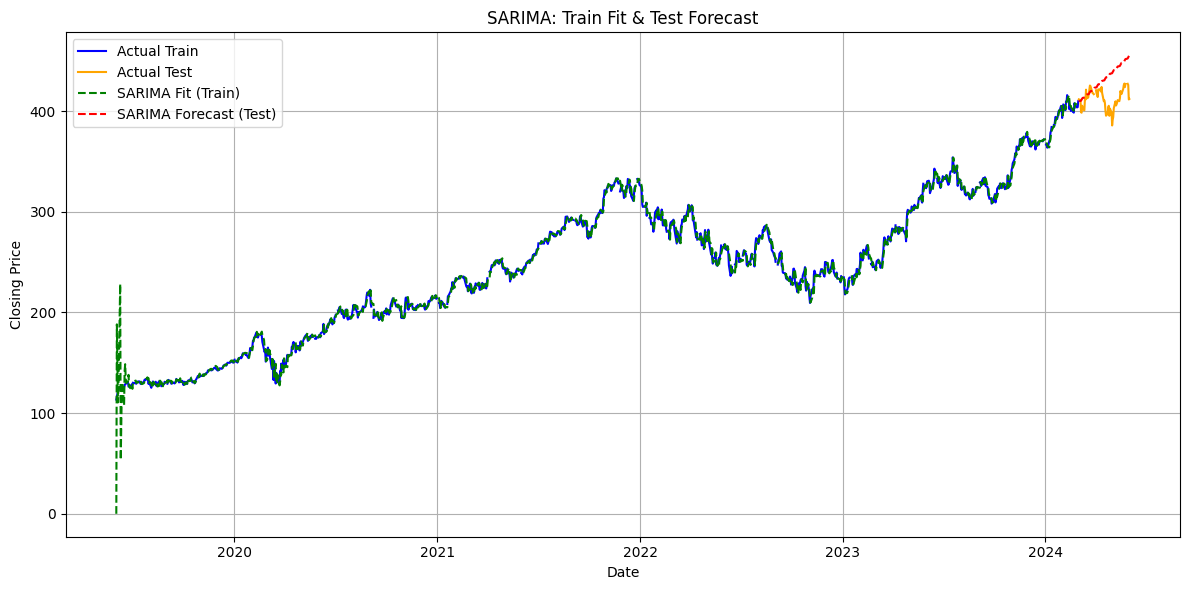

In [29]:
# Fitted values on train
sarima_fitted_values = sarima_result.fittedvalues

# Forecast on test
forecast_sarima = sarima_result.forecast(steps=len(test))
forecast_sarima.index = test.index  # Align with test set

# Plot everything
plt.figure(figsize=(12, 6))
plt.plot(train, label="Actual Train", color='blue')
plt.plot(test, label="Actual Test", color='orange')
plt.plot(sarima_fitted_values, label="SARIMA Fit (Train)", color='green', linestyle='--')
plt.plot(forecast_sarima, label="SARIMA Forecast (Test)", color='red', linestyle='--')

plt.title("SARIMA: Train Fit & Test Forecast")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Drop NaNs from both fitted and actual train data
sarima_fitted_values_clean = sarima_fitted_values.dropna()
train_aligned = train.loc[sarima_fitted_values_clean.index].dropna()

# Ensure matching index
common_index = sarima_fitted_values_clean.index.intersection(train_aligned.index)

# Filter both to matching dates only and drop NaNs again (final cleanup)
fitted_final = sarima_fitted_values_clean.loc[common_index].dropna()
train_final = train_aligned.loc[common_index].dropna()

# Final safeguard: ensure same length
min_len = min(len(train_final), len(fitted_final))
train_final = train_final[-min_len:]
fitted_final = fitted_final[-min_len:]

# Test RMSE for SARIMA
forecast_sarima_clean = forecast_sarima.dropna()
test_clean = test.loc[forecast_sarima_clean.index].dropna()

# Align lengths
min_len_test = min(len(forecast_sarima_clean), len(test_clean))
forecast_sarima_final = forecast_sarima_clean[-min_len_test:]
test_final = test_clean[-min_len_test:]


rmse = np.sqrt(mean_squared_error(test_final, forecast_sarima_final))
mape = mean_absolute_percentage_error(test_final, forecast_sarima_final)

print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}%")



RMSE: 25.542
MAPE: 0.051%
